# Experiments and results

Here the results of the experiments are plotted.

### Plotting functions

In [1]:
import sys
sys.path.append("src/")

import configuration
from constants import Constants as CT
import os
import tensorflow as tf
import glob
import pandas as pd
from matplotlib import pyplot as plt

from tensorflow.python.framework.errors_impl import DataLossError
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    """
    Curve smoothing https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter
    """
    import numpy as np
    from math import factorial
    y = np.array(y)
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

def get_single_series(path_to_events_file, scalar_key):
    model_name = path_to_events_file.split(os.path.sep)[-2]
#     print("\tGetting %s" % (scalar_key))#, model_name))
    steps = []
    values = []
    iterator = tf.train.summary_iterator(path_to_events_file)
    stop = False
    errors = 0
    while not stop:
        try:
            e = next(iterator)
        except StopIteration:
            stop = True
        except DataLossError:
            errors += 1
#     for e in iterator:   
        for v in e.summary.value:
            if scalar_key in v.tag:
                #print("\t\t\t\t%s" % str(v.tag))
                values.append(v.simple_value)
                steps.append(e.step)
    series = pd.Series(index = steps, data = values)
    print("\tGot %d of %s (%d errors)" % (len(series), scalar_key, errors))
    return series

def get_all_series_averaged(folder_keys, scalar_key, experiment_folder,
                                                                steps_mode, smooth = True):
    assert os.path.isdir(experiment_folder), "Not a dir: %s" % experiment_folder
    folder_keys = [folder_keys] if type(folder_keys) is not list else folder_keys
    print("Searching for folder_keys='%s'" % str(folder_keys))
    series_list = []
    run_paths = []
    for f in os.listdir(experiment_folder):
        if all([folder_key in f for folder_key in folder_keys]):
            run_paths.append(os.path.join(experiment_folder, f))
                              
    assert len(run_paths) > 0, "No matches"
    training_times = []
    for run_path in run_paths:
        try:
            path_to_events_file = glob.glob(os.path.join(run_path,'events.out*'))[0]
        except IndexError:
            print("\tHasn't even started" % run_path)
            series = pd.Series()
        else:
            series = get_single_series(path_to_events_file, scalar_key)
        try:
            with open(os.path.join(run_path,'total_training_seconds.txt')) as fp:
                content = fp.read()
            training_time = float(content) / 3600
            training_times.append(training_time)
        except:
            print("\tNot finished (length = %d) " % len(series))
        series_list.append(series)
        
    min_length = min([len(series) for series in series_list])
    series_list = [series[:min_length] for series in series_list]
    
    df = pd.DataFrame(series_list)
    means = df.mean(axis = 0)
    if smooth:
        means = savitzky_golay(means, 51, 3)
    stds = df.std(axis = 0)
    steps = df.columns.to_series()
    
    if steps_mode == 'millions':
        steps /= 1e6
    elif steps_mode == 'thousands':
        steps /= 1e3
    try:
        avg_training_time = sum(training_times) / len(training_times)
    except:
        avg_training_time = -1
    data = {'means'      : means,
            'stds'       : stds,
            'steps'      : steps,
            'time'       : avg_training_time,
            'scalar_key' : scalar_key,
            'folder_keys': folder_keys}
                
    return data


def get_datas(folder_keys, scalar_key, experiment_folder, steps_mode):
    datas = []
    for folder_key in folder_keys:
        data = get_all_series_averaged(folder_keys = folder_key,
                                       scalar_key = scalar_key,
                                       experiment_folder = experiment_folder,
                                       steps_mode = steps_mode)
        datas.append(data)    
    return datas

def custom_subplot(data, label, time, logscale = False, color = None):
    err, means, steps, t = data['stds'], data['means'], data['steps'], data['time']
    if len(steps) == 0:
        print("(empty)")
        return
    if time:
        final_label = "(%.1fh) %s" % (t, label)
    else:
        final_label = label
    if not color:
        plt.plot(steps, means, label = final_label)
        plt.fill_between(steps,
                         means - err,
                         means + err,
                         alpha = alpha, linewidth = linewidth)
    else:
        plt.plot(steps, means, label = final_label, color = color)
        plt.fill_between(steps,
                         means - err,
                         means + err,
                         alpha = alpha, linewidth = linewidth,
                         color = color)
        
    if logscale:
        plt.yscale('log')
    
def make_plot(datas, labels, time = True, legend_loc = 'lower right', title = None):
    plt.figure(figsize = figsize)
    for data, label in zip(datas, labels):
        custom_subplot(data, label, time)
    title = data['scalar_key'] if not title else title
    plt.ylabel(title, fontsize = fontsize)
    plt.xlabel('%s of steps' % steps_mode.capitalize(), fontsize = fontsize)
    plt.legend(fontsize = fontsize,
               loc = legend_loc)
    plt.show()  

# Global variables:
gl = configuration.GlobalSettings()
alpha = .3
linewidth = 0
fontsize = 15
figsize = (12, 7)
steps_mode = 'millions'
scalar_key = 'avg_ep_reward'
debug = 0

## Key MDP

In [47]:

experiment_folder = '/mnt/data_disk/Hierarchical-DRL-Tensorflow/Others/logs/17d18h46m53s_key_exp'
labels = ['Double DQN', 'Vanilla DQN', 'Vanilla hDQN']
folder_keyss = [['atdqn', 'dq1'], ['atdqn', 'dq0'], ['hdqn']]
# Avg ep rewards
data_rewards = []
data_steps = []
for folder_keys in folder_keyss:
    reward_scalar_key = 'mc_avg_ep_reward' if 'hdqn' in folder_keys else 'avg_ep_reward'
    step_scalar_key = '/c_steps_per_episode' if 'hdqn' in folder_keys else 'steps_per_episode'
    data_reward = get_all_series_averaged(folder_keys = folder_keys,
                                   scalar_key = reward_scalar_key,
                                   experiment_folder = experiment_folder,
                                   steps_mode = steps_mode)
    data_rewards.append(data_reward)
    data_step = get_all_series_averaged(folder_keys = folder_keys,
                                   scalar_key = step_scalar_key,
                                   experiment_folder = experiment_folder,
                                   steps_mode = steps_mode)
    data_steps.append(data_step)
    
    


Searching for folder_keys='['atdqn', 'dq1']'
	Got 498 of avg_ep_reward (0 errors)
	Got 498 of avg_ep_reward (1 errors)
Searching for folder_keys='['atdqn', 'dq1']'
	Got 498 of steps_per_episode (0 errors)
	Got 498 of steps_per_episode (1 errors)
Searching for folder_keys='['atdqn', 'dq0']'
	Got 499 of avg_ep_reward (1 errors)
	Got 499 of avg_ep_reward (1 errors)
Searching for folder_keys='['atdqn', 'dq0']'
	Got 499 of steps_per_episode (1 errors)
	Got 499 of steps_per_episode (1 errors)
Searching for folder_keys='['hdqn']'
	Got 499 of mc_avg_ep_reward (1 errors)
	Got 499 of mc_avg_ep_reward (1 errors)
Searching for folder_keys='['hdqn']'
	Got 498 of /c_steps_per_episode (1 errors)
	Got 498 of /c_steps_per_episode (1 errors)


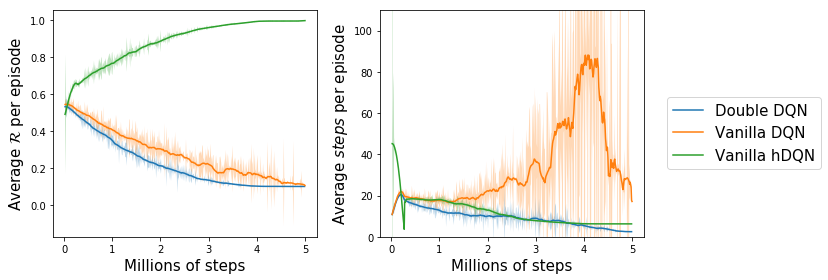

In [92]:
plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
for data_reward, label in zip(data_rewards, labels):
    custom_subplot(data_reward, label, time = False)
plt.ylabel('Average $\mathcal{R}$ per episode', fontsize = fontsize)
plt.xlabel("Millions of steps", fontsize = fontsize)
plt.subplot(1, 2, 2)
for data_step, label in zip(data_steps, labels):
    custom_subplot(data_step, label, time = False, logscale = 0)
    plt.ylim([0, 110])
plt.ylabel('Average $steps$ per episode', fontsize = fontsize)
plt.xlabel("Millions of steps", fontsize = fontsize)
plt.legend(fontsize = fontsize,
            bbox_to_anchor=(1.7, .65))
plt.tight_layout()
plt.show()

In [109]:
experiment_folder = '/mnt/data_disk/Hierarchical-DRL-Tensorflow/Others/logs/17d18h46m53s_key_exp'
folder_keys = ['hdqn']
goals = list(range(9))
datas = []
for goal in goals:
    scalar_key = 'g%d_rfreq' % goal    
    data = get_all_series_averaged(folder_keys = folder_keys,
                                   scalar_key = scalar_key,
                                   experiment_folder = experiment_folder,
                                   steps_mode = steps_mode)
    datas.append(data)

Searching for folder_keys='['hdqn']'
	Got 499 of g0_rfreq (1 errors)
	Got 499 of g0_rfreq (1 errors)
Searching for folder_keys='['hdqn']'
	Got 499 of g1_rfreq (1 errors)
	Got 499 of g1_rfreq (1 errors)
Searching for folder_keys='['hdqn']'
	Got 499 of g2_rfreq (1 errors)
	Got 499 of g2_rfreq (1 errors)
Searching for folder_keys='['hdqn']'
	Got 499 of g3_rfreq (1 errors)
	Got 499 of g3_rfreq (1 errors)
Searching for folder_keys='['hdqn']'
	Got 499 of g4_rfreq (1 errors)
	Got 499 of g4_rfreq (1 errors)
Searching for folder_keys='['hdqn']'
	Got 499 of g5_rfreq (1 errors)
	Got 499 of g5_rfreq (1 errors)
Searching for folder_keys='['hdqn']'
	Got 499 of g6_rfreq (1 errors)
	Got 499 of g6_rfreq (1 errors)
Searching for folder_keys='['hdqn']'
	Got 499 of g7_rfreq (1 errors)
	Got 499 of g7_rfreq (1 errors)
Searching for folder_keys='['hdqn']'
	Got 499 of g8_rfreq (1 errors)
	Got 501 of g8_rfreq (1 errors)


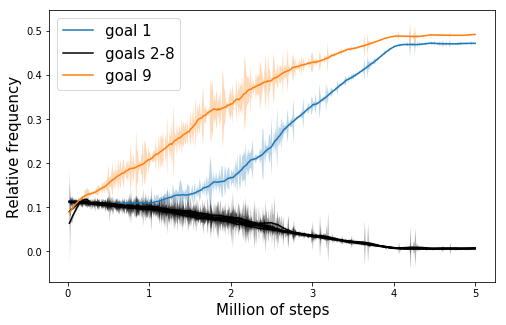

In [134]:
from collections import OrderedDict
plt.figure(figsize = (8, 5))
for data in datas:
    goal = int(data['scalar_key'][1]) + 1
    label = "goal %d" % goal if goal in [1, 9] else "goals 2-8"
    color = None if goal in [1, 9] else 'black'
    custom_subplot(data, label, time = False, logscale = 0, color = color)
plt.ylabel("Relative frequency", fontsize = fontsize)
plt.xlabel("Million of steps", fontsize = fontsize)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize = fontsize)
plt.show()

### h-DQN ablation of extensions

In [14]:
def get_folder_keys(target_module, ablation):
    folder_keys = []
    for module in module_keys:        
        for extension in extensions.keys():
            activated = int(ablation != extension or module != target_module)
            if ablation == 'all':
                activated = 0
            folder_key = "_%s%s%d_" % (module, extension, activated)
            folder_keys.append(folder_key)
    return folder_keys
module_keys = ['C', 'MC']
extensions = {'dq'  : 'Double Q',
              'd'   : 'Dueling',
              'p'   : 'Prioritized Replay',
              'None': 'Rainbow',
              'All' : 'Vanilla'}

In [17]:

print(get_folder_keys('MC', 'None'))

['_Cp1_', '_Cdq1_', '_Cd1_', '_CAll1_', '_CNone1_', '_MCp1_', '_MCdq1_', '_MCd1_', '_MCAll1_', '_MCNone0_']


In [2]:
def get_folder_keys(target_module, ablation):
    folder_keys = []
    for module in module_keys:        
        for extension in extensions.keys():
            activated = int(ablation != extension or module != target_module)
            if ablation == 'all':
                activated = 0
            folder_key = "_%s%s%d_" % (module, extension, activated)
            folder_keys.append(folder_key)
    return folder_keys
module_keys = ['C', 'MC']
debug = 0
extensions = {'dq'  : 'Double Q',
              'd'   : 'Dueling',
              'p'   : 'Prioritized Replay'}
datass = []
experiment_folder = '/vol/tensusers/vgarciacazorla/logs/18d18h26m07s_ablation_exp'
for module in module_keys:
    datas = []
    scalar_key = '/%s_total_reward' % module.lower()
    for ablation in list(extensions.keys()) + [None, 'all']:
        folder_keys = get_folder_keys(module, ablation)
        
        data = get_all_series_averaged(folder_keys = folder_keys,
                                       scalar_key = scalar_key,
                                       experiment_folder = experiment_folder,
                                       steps_mode = steps_mode)
        datas.append(data)
    
    datass.append(datas)    
# mc_rainbow_data = get_all_series_averaged(folder_keys = get_folder_keys('', ''),
#                                        scalar_key = '/mc_total_reward',
#                                        experiment_folder = experiment_folder,
#                                        steps_mode = steps_mode)
# c_rainbow_data = get_all_series_averaged(folder_keys = get_folder_keys('', ''),
#                                        scalar_key = '/c_total_reward',
#                                        experiment_folder = experiment_folder,
#                                        steps_mode = steps_mode)

Searching for folder_keys='['_Cd0_', '_Cp1_', '_Cdq1_', '_MCd1_', '_MCp1_', '_MCdq1_']'
	Got 1498 of /c_total_reward (0 errors)
	Got 1498 of /c_total_reward (0 errors)
Searching for folder_keys='['_Cd1_', '_Cp0_', '_Cdq1_', '_MCd1_', '_MCp1_', '_MCdq1_']'
	Got 1498 of /c_total_reward (0 errors)
	Got 1498 of /c_total_reward (0 errors)
Searching for folder_keys='['_Cd1_', '_Cp1_', '_Cdq0_', '_MCd1_', '_MCp1_', '_MCdq1_']'
	Got 1498 of /c_total_reward (0 errors)
	Got 1498 of /c_total_reward (0 errors)
Searching for folder_keys='['_Cd1_', '_Cp1_', '_Cdq1_', '_MCd1_', '_MCp1_', '_MCdq1_']'
	Got 1498 of /c_total_reward (0 errors)
	Got 1498 of /c_total_reward (0 errors)
Searching for folder_keys='['_Cd0_', '_Cp0_', '_Cdq0_', '_MCd0_', '_MCp0_', '_MCdq0_']'
	Got 1498 of /c_total_reward (0 errors)
	Got 1498 of /c_total_reward (0 errors)
Searching for folder_keys='['_Cd1_', '_Cp1_', '_Cdq1_', '_MCd0_', '_MCp1_', '_MCdq1_']'
	Got 1498 of /mc_total_reward (0 errors)
	Got 1498 of /mc_total_reward (

In [5]:
data['folder_keys']

['_Cd1_', '_Cp1_', '_Cdq1_', '_MCd1_', '_MCp1_', '_MCdq1_']

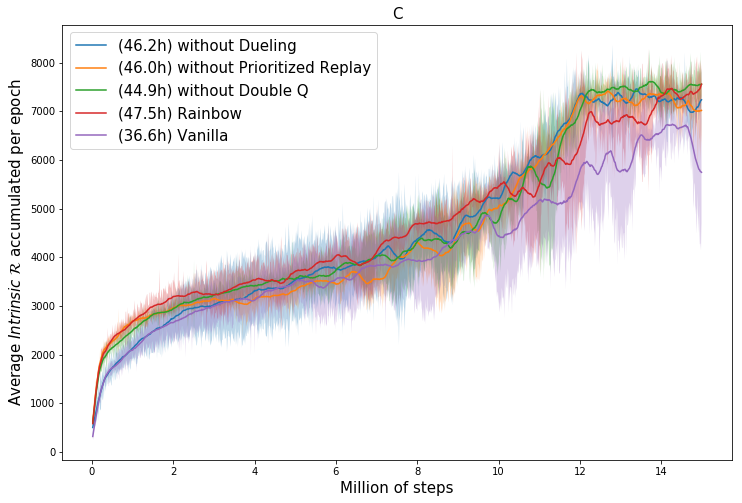

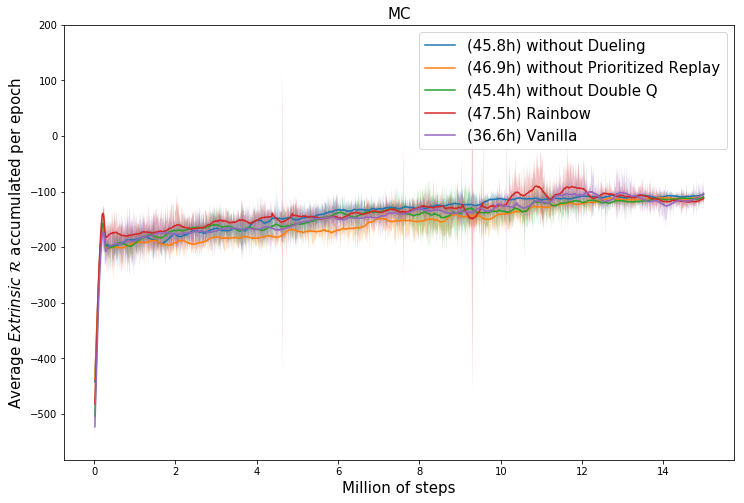

In [10]:
# plt.figure(figsize = (12, 8))
total_figures = 2
rewards = ['$Intrinsic$', '$Extrinsic$']
for i in range(total_figures):
    module = module_keys[i]
    datas = datass[i]
    plt.figure(figsize = (12, 8))
#     plt.subplots(1, 2, i + 1)
    for data in datas:
        if all(['0' in fk for fk in data['folder_keys']]):
            label = 'Vanilla'
        elif all(['1' in fk for fk in data['folder_keys']]):
            label = 'Rainbow'
        else:
            ablation = [fk for fk in data['folder_keys'] if '0' in fk][0][1:-2].replace(module, '')
            label = "without %s" % extensions[ablation]
        custom_subplot(data, label, time = 1)  
    plt.xlabel("Million of steps", fontsize = fontsize)
    plt.ylabel("Average %s $\mathcal{R}$ accumulated per epoch" % rewards[i], fontsize = fontsize)
    plt.title(module, fontsize = fontsize)
    plt.legend(fontsize = fontsize)
    plt.show()
    
    
    

### Goals and action repeat

In [27]:
experiment_folder = '/vol/tensusers/vgarciacazorla/logs/13d23h46m56s_goals_exp'
steps_mode = 'millions'  
action_repeats = [1, 3, 5]
datass = []
goal_groups = [0, 1, 2]

for gg in goal_groups:
    datas = []
    for ar in action_repeats:
        folder_keys = ['_ar%d_' % ar]
        if gg != 0:
            folder_keys.append("gg%d" % gg)
            scalar_key = 'mc_total_reward'
        else:
            folder_keys.append("atdqn")
            scalar_key = 'total_reward'
        scalar_key = 'win_rate'
        data = get_all_series_averaged(folder_keys = folder_keys,
                                       scalar_key = scalar_key,
                                       experiment_folder = experiment_folder,
                                       steps_mode = steps_mode)
        datas.append(data)
    datass.append(datas)

Searching for folder_keys='['_ar1_', 'atdqn']'
	Getting win_rate
	Getting win_rate
	Getting win_rate
Searching for folder_keys='['_ar3_', 'atdqn']'
	Getting win_rate
	Getting win_rate
	Getting win_rate
Searching for folder_keys='['_ar5_', 'atdqn']'
	Getting win_rate
	Getting win_rate
	Getting win_rate
Searching for folder_keys='['_ar1_', 'gg1']'
	Getting win_rate
	Getting win_rate
	Not finished (length = 994) 
	Getting win_rate
	Not finished (length = 993) 
Searching for folder_keys='['_ar3_', 'gg1']'
	Getting win_rate
	Not finished (length = 994) 
	Getting win_rate
	Not finished (length = 901) 
	Getting win_rate
	Not finished (length = 979) 
Searching for folder_keys='['_ar5_', 'gg1']'
	Getting win_rate
	Not finished (length = 900) 
	Getting win_rate
	Not finished (length = 940) 
	Getting win_rate
	Not finished (length = 877) 
Searching for folder_keys='['_ar1_', 'gg2']'
	Getting win_rate
	Getting win_rate
	Getting win_rate
Searching for folder_keys='['_ar3_', 'gg2']'
	Getting win_rat

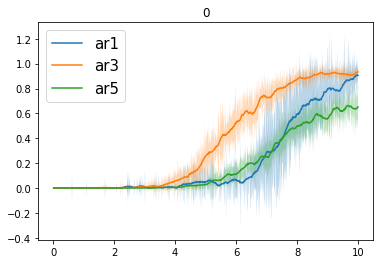

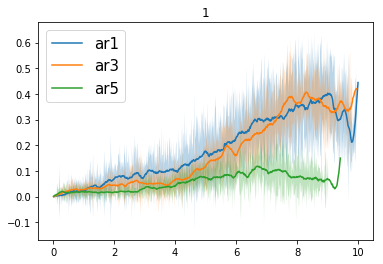

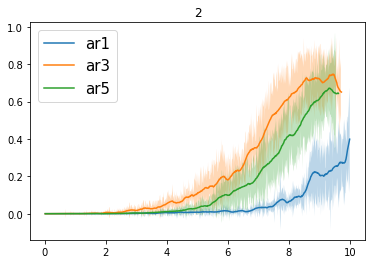

In [28]:
for gg in goal_groups:
    datas = datass[gg]
    plt.figure()
    for data in datas:
        label = data['folder_keys'][0][1:-1]#''.join()
        custom_subplot(data, label, time = False)
    plt.title(str(gg))
    plt.legend(fontsize = fontsize)
    plt.show()

### Intrinsic reward time penalty

In [69]:
experiment_folder = '/vol/tensusers/vgarciacazorla/logs/13d23h47m00s_intrinsic_exp'
steps_mode = 'millions'   
labels = ['With time penalty', 'Without time penalty']
cits = [ 'Citp0.01',  'Citp0_']
datass = []
goal_groups = [1, 2]
for gg in goal_groups:
    goals = CT.goal_groups['SF-v0'][gg]
    for goal in goals:
        datas = []
        scalar_key = '%s_avg_steps' % goal
        for cit in cits:
            folder_keys = ["gg%d" % gg, cit]
            data = get_all_series_averaged(folder_keys = folder_keys,
                                           scalar_key = scalar_key,
                                           experiment_folder = experiment_folder,
                                           steps_mode = steps_mode)
            datas.append(data)
        datass.append(datas)

Searching for folder_key='['gg1', 'Citp0.01']'
	Getting G_aim_at_fortress_avg_steps
	Getting G_aim_at_fortress_avg_steps
	Getting G_aim_at_fortress_avg_steps
Searching for folder_key='['gg1', 'Citp0_']'
	Getting G_aim_at_fortress_avg_steps
	Getting G_aim_at_fortress_avg_steps
	Getting G_aim_at_fortress_avg_steps
Searching for folder_key='['gg1', 'Citp0.01']'
	Getting G_aim_at_mine_avg_steps
	Getting G_aim_at_mine_avg_steps
	Getting G_aim_at_mine_avg_steps
Searching for folder_key='['gg1', 'Citp0_']'
	Getting G_aim_at_mine_avg_steps
	Getting G_aim_at_mine_avg_steps
	Getting G_aim_at_mine_avg_steps
Searching for folder_key='['gg1', 'Citp0.01']'
	Getting G_double_shoot_avg_steps
	Getting G_double_shoot_avg_steps
	Getting G_double_shoot_avg_steps
Searching for folder_key='['gg1', 'Citp0_']'
	Getting G_double_shoot_avg_steps
	Getting G_double_shoot_avg_steps
	Getting G_double_shoot_avg_steps
Searching for folder_key='['gg1', 'Citp0.01']'
	Getting G_single_shoot_avg_steps
	Getting G_single_s

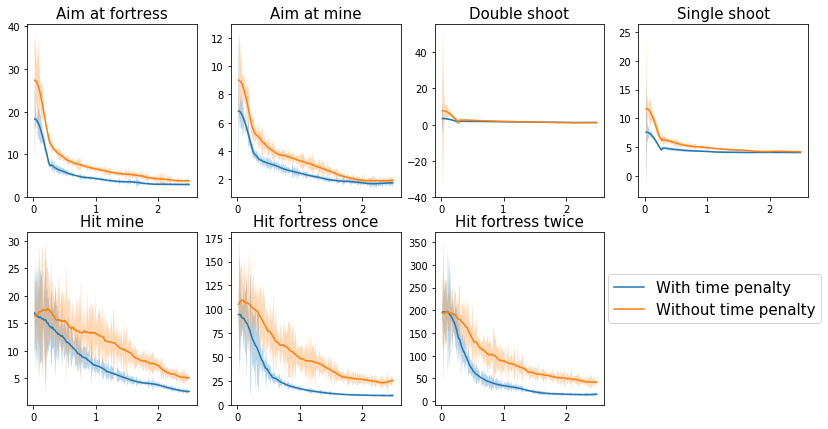

In [76]:
plt.figure(figsize = (14, 7))
columns = 4
rows = 2
total_figures = columns * rows
for i in range(total_figures - 1):
    plot_pos = i + 1
    plt.subplot(rows, columns, plot_pos)
    datas = datass[i]
    for data, label in zip(datas, labels):
        custom_subplot(data, label, time = False)
    title = data['scalar_key'][2:-10].replace('_', ' ').capitalize()
    plt.title(title, fontsize = fontsize)
    if i == total_figures - 2:
        plt.legend(fontsize = fontsize,
                   bbox_to_anchor=(2.32, .8))
        
    
plt.show()

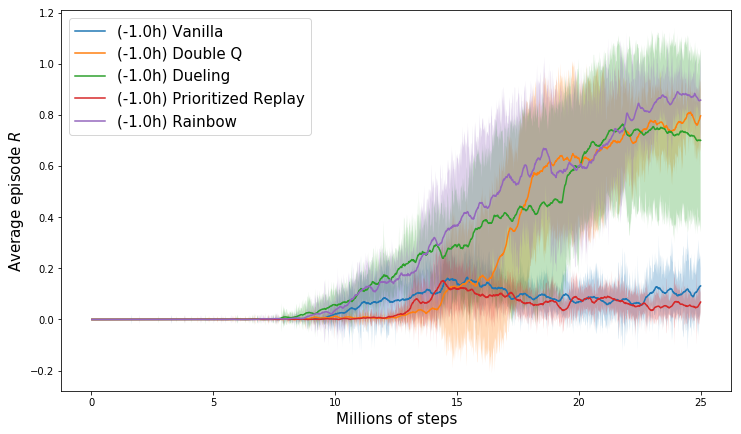

### DQN Extensions

In [ ]:
experiment_folder = '/vol/tensusers/vgarciacazorla/logs/23d20h16m07s_extensions_exp'
labels = ['Vanilla', 'Double Q', 'Dueling', 'Prioritized Replay', 'Rainbow']
folder_keys = [ 'dq0_d0_p0',  'dq1_d0_p0', 'dq0_d1_p0', 'dq0_d0_p1', 'dq1_d1_p1']
scalar_key = 'win_rate'
datas = get_datas(folder_keys, scalar_key, experiment_folder, steps_mode)

In [ ]:
make_plot(datas, labels)

### Action repeat

In [11]:
experiment_folder = '/vol/tensusers/vgarciacazorla/logs/04d09h25m33s_action_repeat_exp'
actions_repeats = list(range(1, 8))
labels = ["ar=%d" % ar for ar in actions_repeats]
folder_keys = ["ar%d_" % ar for ar in actions_repeats]
scalar_key = 'win_rate'
datas = get_datas(folder_keys, scalar_key, experiment_folder, steps_mode)

Searching for folder_key='ar1_'
	Getting win_rate from d04d09h25m33s_gg4_enSF-v0_e1_ma1_athdqn_a512-512_dq0_d0_p0_ar1_rs2
	Not finished
	Getting win_rate from d04d09h25m33s_gg4_enSF-v0_e1_ma1_athdqn_a512-512_dq0_d0_p0_ar1_rs1
	Not finished
	Getting win_rate from d04d09h25m33s_gg4_enSF-v0_e1_ma1_athdqn_a512-512_dq0_d0_p0_ar1_rs0
	Not finished
	Getting win_rate from d04d09h25m33s_gg4_enSF-v0_e1_ma1_athdqn_a512-512_dq0_d0_p0_ar1_rs3
	Not finished
Searching for folder_key='ar2_'
	Getting win_rate from d04d09h25m33s_gg4_enSF-v0_e1_ma1_athdqn_a512-512_dq0_d0_p0_ar2_rs3
	Not finished
	Getting win_rate from d04d09h25m33s_gg4_enSF-v0_e1_ma1_athdqn_a512-512_dq0_d0_p0_ar2_rs1
	Not finished
	Getting win_rate from d04d09h25m33s_gg4_enSF-v0_e1_ma1_athdqn_a512-512_dq0_d0_p0_ar2_rs0
	Not finished
	Getting win_rate from d04d09h25m33s_gg4_enSF-v0_e1_ma1_athdqn_a512-512_dq0_d0_p0_ar2_rs2
	Not finished
Searching for folder_key='ar3_'
	Getting win_rate from d04d09h25m33s_gg4_enSF-v0_e1_ma1_athdqn_a512-512_

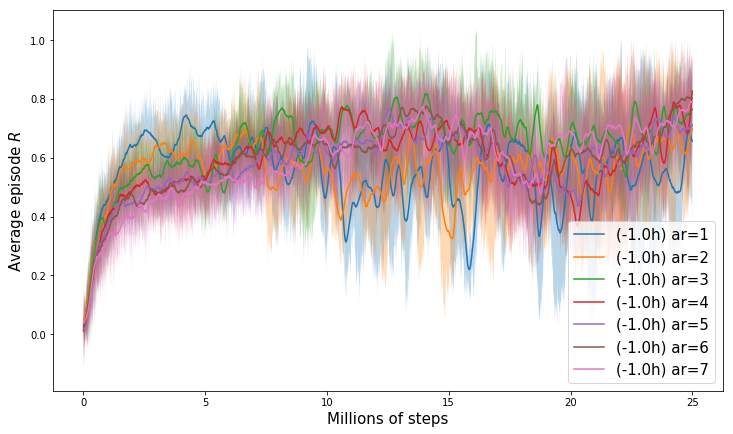

In [12]:
make_plot(datas, labels)

### Architectures

In [ ]:
experiment_folder = '/vol/tensusers/vgarciacazorla/logs/21d18h32m35s_architectures_exp'
architectures = [[16],
                [64, 64],
                [64, 64, 64, 64],
                [512],
                [512, 512],
                [512, 512, 512, 512]]
labels = ['-'.join([str(n) for n in a]) for a in architectures]
folder_keys = ['a' + l + '_' for l in labels]
datas = get_datas(folder_keys, scalar_key, experiment_folder, steps_mode)

### Architectures h-DQN

In [13]:
experiment_folder = '/vol/tensusers/vgarciacazorla/logs/04d09h25m40s_architectures_exp'
architectures = [[16],
                [64],
                [64, 64],
                [64, 64, 64, 64],
                [512],
                [512, 512],
                [512, 512, 512, 512]]
scalar_key = 'win_rate'
labels = ['-'.join([str(n) for n in a]) for a in architectures]
folder_keys = ['a' + l + '_' for l in labels]
datas = get_datas(folder_keys, scalar_key, experiment_folder, steps_mode)

Searching for folder_key='a16_'
	Getting win_rate from d04d09h25m40s_gg4_enSF-v0_e0_ma1_athdqn_a16_dq0_d0_p0_ar6_rs1
	Not finished
	Getting win_rate from d04d09h25m40s_gg4_enSF-v0_e0_ma1_athdqn_a16_dq0_d0_p0_ar6_rs2
	Not finished
	Getting win_rate from d04d09h25m40s_gg4_enSF-v0_e0_ma1_athdqn_a16_dq0_d0_p0_ar6_rs3
	Not finished
	Getting win_rate from d04d09h25m40s_gg4_enSF-v0_e0_ma1_athdqn_a16_dq0_d0_p0_ar6_rs0
	Not finished
Searching for folder_key='a64_'
	Getting win_rate from d04d09h25m40s_gg4_enSF-v0_e0_ma1_athdqn_a64_dq0_d0_p0_ar6_rs3
	Not finished
	Getting win_rate from d04d09h25m40s_gg4_enSF-v0_e0_ma1_athdqn_a64_dq0_d0_p0_ar6_rs2
	Not finished
	Getting win_rate from d04d09h25m40s_gg4_enSF-v0_e0_ma1_athdqn_a64_dq0_d0_p0_ar6_rs1
	Not finished
	Getting win_rate from d04d09h25m40s_gg4_enSF-v0_e0_ma1_athdqn_a64_dq0_d0_p0_ar6_rs0
	Not finished
Searching for folder_key='a64-64_'
	Getting win_rate from d04d09h25m40s_gg4_enSF-v0_e0_ma1_athdqn_a64-64_dq0_d0_p0_ar6_rs0
	Not finished
	Gettin

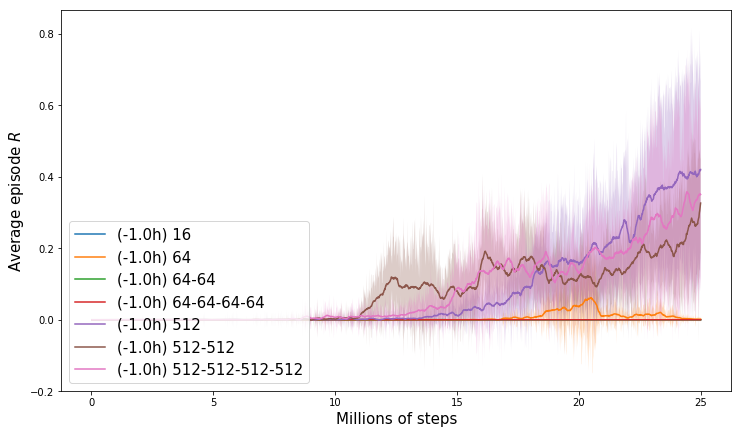

In [14]:
make_plot(datas, labels, legend_loc = 'lower left')

### Goals

In [ ]:
experiment_folder = '/vol/tensusers/vgarciacazorla/logs/04d09h26m01s_goals_exp'
steps_mode = 'millions'
scalar_key = 'c_avg_goal_success'
goal_groups = [2,3,4,5]
labels = ['gg%d' % gg for gg in goal_groups]
folder_keys = labels#['a' + l + '_' for l in labels]
datas = get_datas(folder_keys, scalar_key, experiment_folder, steps_mode)

In [ ]:
make_plot(datas, labels)

## Goal level of hierarchy versus action repeat

In [8]:
experiment_folder = '/vol/tensusers/vgarciacazorla/logs/10d17h18m46s_goals_exp'
steps_mode = 'millions'
scalar_key = 'win_rate'
goal_groups = [2,3]
labels = ['gg_'] + ['gg%d' % gg for gg in goal_groups]
folder_keys = labels#['a' + l + '_' for l in labels]
datas = get_datas(folder_keys, scalar_key, experiment_folder, steps_mode)

Searching for folder_key='gg_'
	Getting win_rate from d10d17h18m46s_gg_enSF-v0_e0_ma1_atdqn_a512-512_dq0_d0_p0_ar1_rs0
	Not finished
	Getting win_rate from d10d17h18m46s_gg_enSF-v0_e0_ma1_atdqn_a512-512_dq0_d0_p0_ar5_rs0
	Not finished
	Getting win_rate from d10d17h18m46s_gg_enSF-v0_e0_ma1_atdqn_a512-512_dq0_d0_p0_ar7_rs1
	Not finished
	Getting win_rate from d10d17h18m46s_gg_enSF-v0_e0_ma1_atdqn_a512-512_dq0_d0_p0_ar1_rs1
	Not finished
	Getting win_rate from d10d17h18m46s_gg_enSF-v0_e0_ma1_atdqn_a512-512_dq0_d0_p0_ar3_rs1
	Not finished
	Getting win_rate from d10d17h18m46s_gg_enSF-v0_e0_ma1_atdqn_a512-512_dq0_d0_p0_ar3_rs0
	Not finished
	Getting win_rate from d10d17h18m46s_gg_enSF-v0_e0_ma1_atdqn_a512-512_dq0_d0_p0_ar3_rs2
	Not finished
	Getting win_rate from d10d17h18m46s_gg_enSF-v0_e0_ma1_atdqn_a512-512_dq0_d0_p0_ar5_rs2
	Not finished
	Getting win_rate from d10d17h18m46s_gg_enSF-v0_e0_ma1_atdqn_a512-512_dq0_d0_p0_ar5_rs1
	Not finished
	Getting win_rate from d10d17h18m46s_gg_enSF-v0_e0_

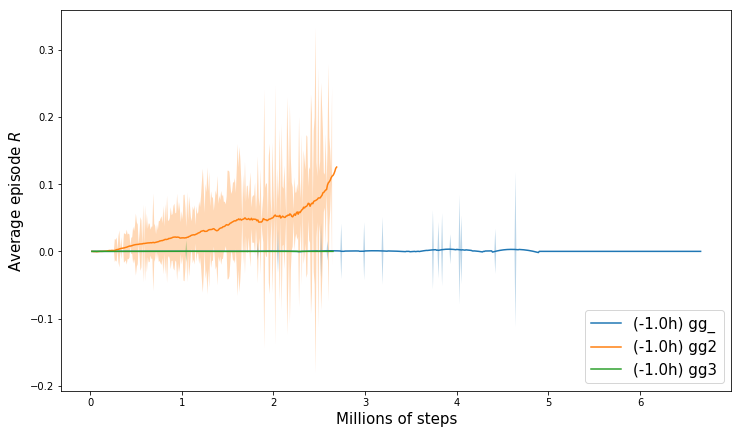

In [9]:
make_plot(datas, labels)